### Introduction

New York City comprises 5 boroughs sitting where the Hudson River meets the Atlantic Ocean. At its core is Manhattan, a densely populated borough that’s among the world’s major commercial, financial and cultural centers. Its iconic sites include skyscrapers such as the Empire State Building and sprawling Central Park. Broadway theater is staged in neon-lit Times Square.

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.
So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

### Data

Data For this project we need the following data :

We would be looking at the New york data that has Boroughs, Neighborhoods along with their geo-location. 

Data source : https://cocl.us/new_york_dataset
Description : This data set contains the needed data for the prediction. And we would use the data to examine the neighborhoods of new york.

Data source : Fousquare API 
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants. 

GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm 
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

### Methodology 

1) Collect the new york data from https://cocl.us/new_york_dataset
2) Using FourSquare API we will find all venues for each neighborhood.
3) Cleaning the data set.
4) Find rating , tips and like count using FourSquare API.
5) Visualize the Ranking of neighborhoods using folium library(python)

### Anwers to be derivred from dataset

1) which location in New York City for good Indian Cuisine ?
2) Which areas may have Indian Resturant Market ?
3) Which areas lack Resturants ?
4) Which place is the best ?

### Analysis

### Required Libraries

1) pandas and numpy for handling data.
2) request module for using FourSquare API.
3) geopy to get co-ordinates of City of New York.
4) folium to visualize the results on a map

### we import our libraries

pip install geocoder #rerun if using a new device

pip install folium  #rerun if using a new device

pip install geopy #rerun if using a new device

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#### we derive latitude and longitude of a given location using geocoder

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

##### We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0NKVL1FDL5ONZ3PXXXK0GXBX3WNQ3RMK1RNIXJLAXE5NPP2Y' 
    CLIENT_SECRET = '52PSTDRWBO4B32H3U2BBFTSHVHWGS5EVY2DEOYBUTCSIJ4TO' 
    VERSION = '20201120' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

##### define a function to get venue details like like count , rating , tip counts for a given venue id. 

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0NKVL1FDL5ONZ3PXXXK0GXBX3WNQ3RMK1RNIXJLAXE5NPP2Y' 
    CLIENT_SECRET = '52PSTDRWBO4B32H3U2BBFTSHVHWGS5EVY2DEOYBUTCSIJ4TO' 
    VERSION = '20201120' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### define a funtion to get the new york city data such as Boroughs, Neighborhoods along with geo loacation

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

This shows that we have 306 neighborheed in new york, derived with Borough, latitude and longitude geo location

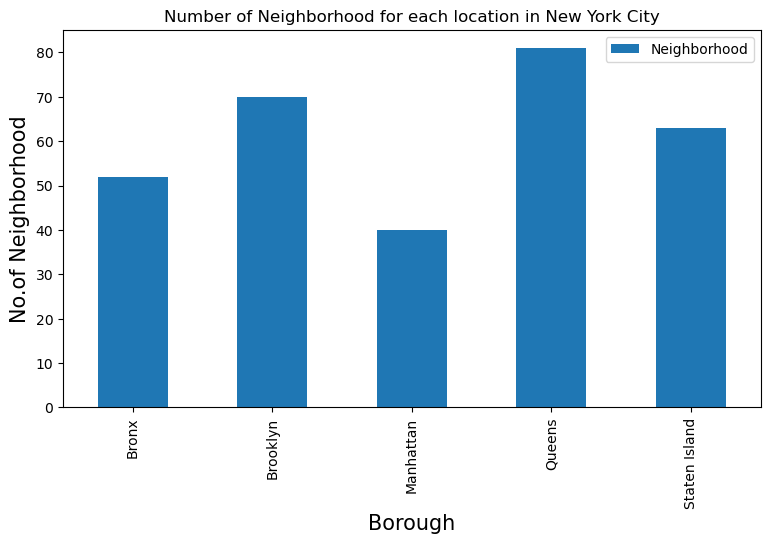

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each location in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has highest number of neighborhoods, followed by Brooklyn in thrid position is Staten island, fourth is Bronx and the least neighborhoods is Manhattan

lets locate the indian resturants in each location

In [9]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:1
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

Now that we have got all the indian resturants in new york city , lets analyze them

In [10]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal


In [11]:
indian_rest_ny.shape

(147, 4)

We are able to identify 147 indian resturant in New york

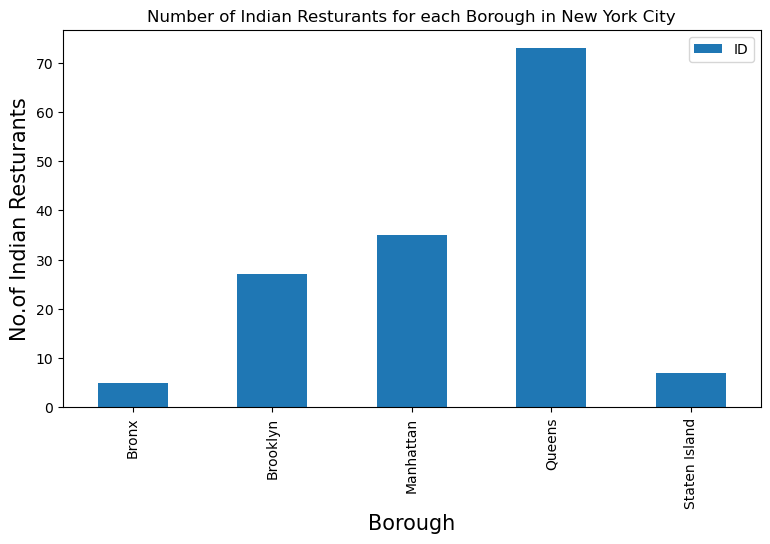

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queen has the highest number of indian resturant followed by Manhattah and Brooklyn

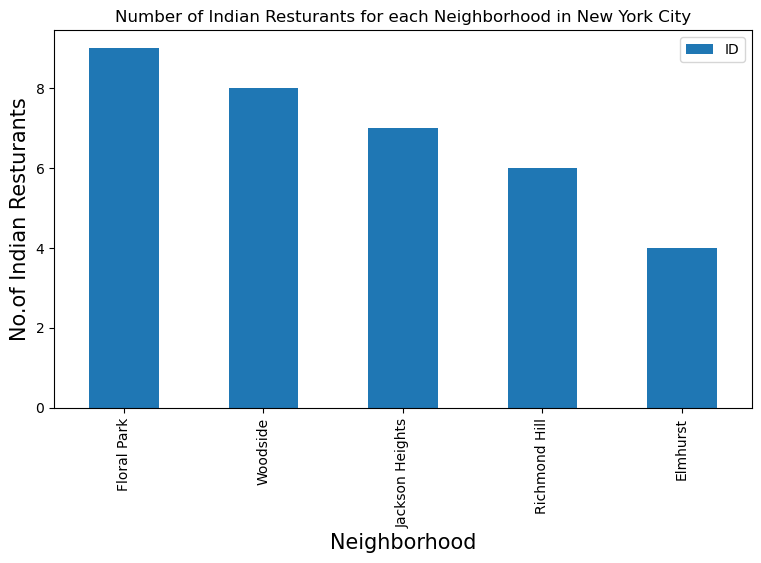

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [14]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
102,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
103,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
104,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
108,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
109,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


Floral Park in Queens has the highest number of Indian Resturants with a total count of 9.

Lets generate the ranking of each resturant for further analysis.

In [15]:
# neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.7    10
( 1 / 147 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 570c3a3fcd10eecd0d0434cd
( 2 / 147 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.1     9
( 3 / 147 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     4
( 4 / 147 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     8.1    24
( 5 / 147 ) processed
                         ID          Name  Likes  Rating  Tips
0  545835a1498e820edc6f636f  Bombay Grill     13     7.2     4
( 6 / 147 ) processed
                         ID          Name  Likes  Rating  Tips
0  4af0d31bf964a5207ddf21e3  Pak Nasheman     10     

In [16]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,4
4,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,37,8.1,24


In [17]:
indian_rest_stats_ny.shape

(147, 7)

In [18]:
indian_rest_ny.shape

(147, 4)

lets save this data to a csv sheet. due to the free account we are working with 

In [19]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [20]:
new_york_data.to_csv('new_york_data.csv', index=False)

In [21]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [22]:
new_york_data_csv=pd.read_csv('new_york_data.csv')

In [23]:
indian_rest_stats_ny_csv.shape

(147, 7)

In [24]:
new_york_data_csv.shape

(306, 4)

In [25]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Williamsbridge,0,0,0,0.0,0
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,4
4,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal,37,8.1,24


In [26]:
new_york_data_csv.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [27]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       147 non-null    object 
 1   Neighborhood  147 non-null    object 
 2   ID            147 non-null    object 
 3   Name          147 non-null    object 
 4   Likes         147 non-null    object 
 5   Rating        147 non-null    float64
 6   Tips          147 non-null    object 
dtypes: float64(1), object(6)
memory usage: 8.2+ KB


In [28]:
new_york_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       306 non-null    object 
 1   Neighborhood  306 non-null    object 
 2   Latitude      306 non-null    float64
 3   Longitude     306 non-null    float64
dtypes: float64(2), object(2)
memory usage: 9.7+ KB


We would need to convert to floats in other to work with the data

In [29]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [30]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [31]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       147 non-null    object 
 1   Neighborhood  147 non-null    object 
 2   ID            147 non-null    object 
 3   Name          147 non-null    object 
 4   Likes         147 non-null    float64
 5   Rating        147 non-null    float64
 6   Tips          147 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB


In [32]:
# Resturant with highest Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                              835.0
Rating                               8.6
Tips                               258.0
Name: 38, dtype: object

In [33]:
# Resturant with highest Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood            Long Island City
ID              5b931ea69d7468002c3b1382
Name                                Adda
Likes                              171.0
Rating                               9.1
Tips                                40.0
Name: 81, dtype: object

In [34]:
# Resturant with highest Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                              835.0
Rating                               8.6
Tips                               258.0
Name: 38, dtype: object

In [35]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [36]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
42,Long Island City,9.1
5,Blissville,9.1
69,Sunnyside,9.1
65,Soho,8.8
74,Turtle Bay,8.7
73,Tudor City,8.7
48,Murray Hill,8.7
14,Clinton Hill,8.6
45,Midtown,8.6
46,Midtown South,8.6


In 2020 Tribeca and Greenwich Village both have a rating of 9 points
but now they are not part of the top 10 in 2022

In [37]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [38]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.177143
1,Brooklyn,7.244444
3,Queens,6.491781
0,Bronx,5.480000
4,Staten Island,4.628571


Lets visualize it

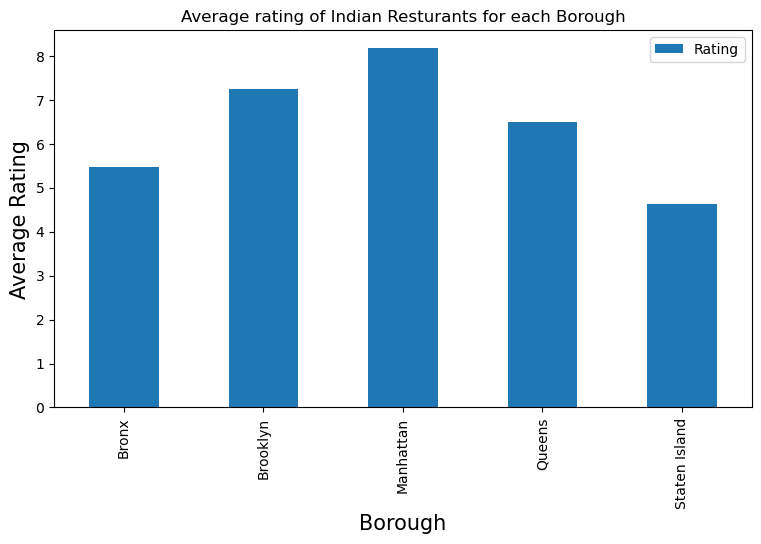

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [41]:
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Blissville,9.1
42,Long Island City,9.1
69,Sunnyside,9.1


In 2020 Greenwich Village and Tribeca has the highest avg rating making them the best, but after two years Blissvile, Long island city and Sunnyside are considered the highest rated.
Lets generate the geo location

we would be joining the data of rating with the New york data set in other to get the geo location

In [42]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [43]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [51]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Queens,Blissville,40.737251,-73.932442,9.1,"Blissville, Queens(9.1)"
1,Queens,Long Island City,40.750217,-73.939202,9.1,"Long Island City, Queens(9.1)"
2,Queens,Sunnyside,40.740176,-73.926916,9.1,"Sunnyside, Queens(9.1)"
3,Staten Island,Sunnyside,40.612760,-74.097126,9.1,"Sunnyside, Staten Island(9.1)"


## MAP VIEW

In [45]:
# We create am mapwith folium
ny_map = folium.Map(location=geo_location('New York'), zoom_start=15)

In [46]:
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='orange',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

adding new items to the map

In [47]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [48]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# RESULTS